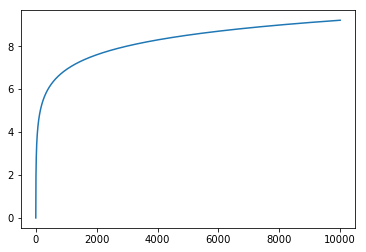

In [3]:
import matplotlib, numpy as np
import matplotlib.pyplot as plt
x = np.arange(1,10000)
y = np.log(x)

plt.plot(x,y)

plt.show()

In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import cPickle as pickle
import pyamg
#import peakutils
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KernelDensity
from collections import defaultdict
from scipy.signal import argrelextrema
from sklearn.neighbors import NearestNeighbors
#from sklearn.feature_selection import SelectKBest
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import KernelPCA
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.feature_selection import chi2
import scipy.sparse as sps
#import networkx as nx
from itertools import combinations
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np
import time
import os

In [ ]:
def cluster(args):
    maindir, file, clusterMethod, n_subgenomes, metric = args
    start = time.clock()
    os.chdir(maindir)
    try:
        n_subgenomes = int(n_subgenomes)
    except:
        n_subgenomes = 2
    n_clusters = n_subgenomes + 1
    clustering_algorithms = {'SpectralClustering': SpectralClustering(n_clusters=n_clusters, eigen_solver='amg', affinity= 'precomputed', random_state=42),#,gamma=1),arpack#amg,affinity="nearest_neighbors")#, n_neighbors=30, gamma=1),# nearestneighbors
                             'KMeans': MiniBatchKMeans(n_clusters=n_clusters)}
    name, algorithm = clusterMethod , clustering_algorithms[clusterMethod]
    if 'recluster' not in file:
        #dataOld = sps.load_npz('clusteringMatrix.npz')
        scaffolds = pickle.load(open('scaffolds.p', 'rb'))
        #kmers = pickle.load(open('kmers.p', 'rb'))
        #kmerIdx = {i : kmer for i, kmer in enumerate(kmers)}
        Tname = file.split('transformed3D')[0]
        transformed_data = np.load(file)
        print 'scaled %f'%(time.clock()-start)
        t1 = time.clock()
        transformed_data = StandardScaler().fit_transform(transformed_data)
        print 'scaled_f %f'%(time.clock()-t1)
        
        if clusterMethod == 'SpectralClustering':
            print 'NN %f'%(time.clock()-start)
            t2 = time.clock()
            neigh = NearestNeighbors(n_neighbors = 10,metric=metric)
            neigh.fit(transformed_data)
            fit_data = neigh.kneighbors_graph(transformed_data)
            print 'NN_f %f'%(time.clock()-t2)
            #print fit_data.toarray()
        else:
            fit_data = transformed_data

        #clustering_names = ['SpectralClustering','KMeans']
        #n_clusters = 3

        #clustering_algorithms = [SpectralClustering(n_clusters=n_clusters,eigen_solver='amg',affinity="nearest_neighbors", gamma=1),MiniBatchKMeans(n_clusters=3)]

        #for name, algorithm in zip(clustering_names, clustering_algorithms):
            #try:
        if 1:#os.path.exists(name + Tname + 'n%d' % n_clusters + 'ClusterTest.html') == 0:
            print 'cluster %f'%(time.clock()-start)
            t3 = time.clock()
            algorithm.fit(fit_data)
            print 'cluster_f %f'%(time.clock()-t3)
            if n_subgenomes > 2:
                reduction = KernelPCA(n_components=3)
                reduction.fit(transformed_data)
                reductionT = reduction.transform(transformed_data)
                scaledfit = StandardScaler()
                scaledfit.fit(reductionT)
                transformed_data2 = scaledfit.transform(reductionT)
            else:
                transformed_data2 = transformed_data
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(transformed_data)
            N = len(set(y_pred))
            c = ['hsl(' + str(h) + ',50%' + ',50%)' for h in np.linspace(0, 360, N)]
            # plot
            plots = []
            clusterSize = defaultdict(list)
            try:
                os.mkdir('analysisOutputs/')
            except:
                pass
            try:
                os.mkdir('analysisOutputs/' + name + Tname + 'n%d' % n_clusters)
            except:
                pass

            for key in set(y_pred):
                # print key
                cluster_scaffolds = np.array(scaffolds)[y_pred == key]
                if list(cluster_scaffolds):
                    clusterSize[key] = np.mean(np.apply_along_axis(lambda x: np.linalg.norm(x),1,transformed_data[y_pred == key,:]))#len(cluster_scaffolds)
                    if clusterSize[key] == min(clusterSize.values()):
                        testCluster = key
                    plots.append(
                        go.Scatter3d(x=transformed_data2[y_pred == key, 0], y=transformed_data2[y_pred == key, 1],
                                     z=transformed_data2[y_pred == key, 2],
                                     name='Cluster %d, %d points, %f distance' % (key, len(cluster_scaffolds),clusterSize[key]), mode='markers',
                                     marker=dict(color=c[key], size=2), text=cluster_scaffolds))

            if hasattr(algorithm, 'cluster_centers_'):
                if n_subgenomes > 2:
                    centers = scaledfit.transform(reduction.transform(algorithm.cluster_centers_)) #FIXME modify!!! need scaler fitted model from transformeddata
                else:
                    centers = algorithm.cluster_centers_
                plots.append(
                    go.Scatter3d(x=centers[:, 0], y=centers[:, 1], z=centers[:, 2], mode='markers',
                                 marker=dict(color='purple', symbol='circle', size=12),
                                 opacity=0.4,
                                 name='Centroids'))
            for key in set(y_pred)-{testCluster}:
                with open('analysisOutputs/' + name + Tname + 'n%d' % n_clusters + '/subgenome_%d.txt' % key, 'w') as f:
                    f.write('\n'.join(np.array(scaffolds)[y_pred == key]))

            fig = go.Figure(data=plots)

            #trainData = transformed_data[y_pred != testCluster]
            #trainData_scaffolds = np.array(scaffolds)[y_pred != testCluster]

            """
            trainLabels = y_pred[y_pred != testCluster]
            trainData = dataOld[y_pred != testCluster]
            kbest = SelectKBest(chi2,k = 500)
            kbest.fit(trainData,trainLabels)
            bestFeatures = kbest.pvalues_.argsort()[:500]
            best_500_kmers = [kmers[i] for i in bestFeatures]
            sps.save_npz('%s/recluster%s_clusteringMatrix.npz' %(reclusterFolder, name + Tname + 'n%d' % n_clusters), dataOld[:,bestFeatures])#.tocsc()#.tocoo())
            with open('%s/kmer500Best_%s.fa'%(kmer500Path,name + Tname + 'n%d' % n_clusters),'w') as f:
                f.write('\n'.join('>%s\n%s'%(kmer,kmer) for kmer in best_500_kmers))
            subprocess.call('touch ' + 'analysisOutputs/' + name + Tname + 'n%d' % n_clusters + '.txt',
                            shell=True)"""

            py.plot(fig, filename=name + Tname + 'n%d' % n_clusters + 'ClusterTest.html')
    

In [ ]:
start = time.clock()
print time.clock()
os.chdir('/Users/JoshuaLevy/PycharmProjects/jupyter/')
cluster(('ClusteringMatrices/tobacco/','main_factor_2_transformed3D.npy','SpectralClustering',2,'cosine'))
print 'total time = ' + str(time.clock() - start)

2.660129
scaled 0.046675
scaled_f 0.006185
NN 0.053147


In [ ]:
time.clock()

In [ ]:
start = time.clock()
print time.clock()
os.chdir('/Users/JoshuaLevy/PycharmProjects/jupyter/')
cluster(('ClusteringMatrices/sweetpotato/','main_factor_3_transformed3D.npy','SpectralClustering',3,'cosine'))
print 'total time = ' + str(time.clock() - start)

In [5]:
start = time.clock()
print time.clock()
os.chdir('/Users/JoshuaLevy/PycharmProjects/jupyter/')
cluster(('ClusteringMatrices/ABR/','main_factor_2_transformed3D.npy','SpectralClustering',2,'euclidean'))
print 'total time = ' + str(time.clock() - start)